## Setting up the Data

In [1]:
import datasets
import torch
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt  
from io import StringIO

In [2]:
# Loading the dataset from the laptop
dataset = datasets.load_from_disk('split_pasta_dataset')

In [3]:
# Displaying how the dataset looks like
dataset

DatasetDict({
    train: Dataset({
        features: ['images', 'labels'],
        num_rows: 363
    })
    valid: Dataset({
        features: ['images', 'labels'],
        num_rows: 45
    })
    test: Dataset({
        features: ['images', 'labels'],
        num_rows: 46
    })
})

In [4]:
# Creating a class of the pasta dataset 
class PastaDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, num_classes):
        super().__init__()
        self.dataset = dataset
        self.dataset.set_format('pt')
        self.num_classes = num_classes

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        datapoint = self.dataset[idx]
        img = datapoint['images'].type(torch.float)
        img = img[:, ::4, ::4] # shrinking images by 4 
        label = torch.nn.functional.one_hot(datapoint['labels'], num_classes=self.num_classes)
        label = label.type(torch.float)
        return img, label 

In [5]:
# Creating instances of the class we just created
train_pasta_dataset = PastaDataset(dataset = dataset['train'], num_classes=12)
valid_pasta_dataset = PastaDataset(dataset = dataset['valid'], num_classes=12)
test_pasta_dataset = PastaDataset(dataset = dataset['test'], num_classes=12)

In [6]:
dataset['train'][0]['images'].shape

torch.Size([3, 320, 320])

In [7]:
train_pasta_dataset[1][0].shape

torch.Size([3, 80, 80])

In [8]:
from torch.utils.data import DataLoader

In [9]:
# Creating instances of the DataLoader class
train_data_loader = DataLoader(dataset=train_pasta_dataset, batch_size=16, shuffle=True)
valid_data_loader = DataLoader(dataset=valid_pasta_dataset, batch_size=16, shuffle=False)
test_data_loader = DataLoader(dataset=test_pasta_dataset, batch_size=16, shuffle=False)

In [10]:
train_data_loader

In [11]:
# Getting one batch (of tensors) made of images and labels 
image_batch, label_batch = next(iter(train_data_loader)) 

In [12]:
image_batch.shape
#1st number = batch size 
#2nd number = channels (color)
#3rd/4th number = size of images 

#batch size can change. however, once you set the size of the img, the mode will be able to be trained only on that specific size of the image. 

torch.Size([16, 3, 80, 80])

In [13]:
label_batch.shape

torch.Size([16, 12])

## Building the Model 

In [14]:
from lightning import LightningModule

In [15]:
# Creating a class to build the model
class CNN(LightningModule):
    # Defining the layers of the model 
    def __init__(
        self, 
        input_channels, 
        hidden_channels,
        kernel_size,
        stride, 
        padding, 
        num_classes,
        x_dim,
        y_dim,
        learning_rate
    ):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(
            in_channels=input_channels, 
            out_channels=hidden_channels, 
            kernel_size=kernel_size, 
            stride=stride, 
            padding=padding 
        )
        self.relu1 = torch.nn.ReLU() 

        self.maxpooling1 = torch.nn.MaxPool2d(kernel_size=2) 

        self.conv2 = torch.nn.Conv2d(
            in_channels=hidden_channels,
            out_channels=2*hidden_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding
        )

        self.relu2 = torch.nn.ReLU()

        self.maxpooling2 = torch.nn.MaxPool2d(kernel_size=2)

        self.conv3 = torch.nn.Conv2d(
            in_channels=2*hidden_channels,
            out_channels=hidden_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding
        )

        self.relu3 = torch.nn.ReLU()

        self.maxpooling3 = torch.nn.MaxPool2d(kernel_size=2)
        
        self.output = torch.nn.Linear(in_features=int(hidden_channels*x_dim*y_dim/4/4/4), out_features=num_classes) 

        self.loss = torch.nn.CrossEntropyLoss() 

        self.learning_rate = learning_rate

    # Applying all the model layers 
    def forward(self, x): 
        x = self.conv1(x)
        x = self.relu1(x) 
        x = self.maxpooling1(x) 
        x = self.conv2(x) 
        x = self.relu2(x) 
        x = self.maxpooling2(x) 
        x = self.conv3(x) 
        x = self.relu3(x) 
        x = self.maxpooling3(x) 
        x = x.view(x.size(0), -1) 
        out = self.output(x)
        return out 
        
    # Computing and returning the loss 
    def training_step(self, batch, batch_idx): 
        image_batch, label_batch = batch 
        output = self.forward(image_batch) 
        loss = self.loss(output, label_batch) 
        self.log('training_loss', loss) 
        return loss

    # Doing the same thing for the validation 
    def validation_step(self, batch, batch_idx): 
        image_batch, label_batch = batch 
        output = self.forward(image_batch) 
        loss = self.loss(output, label_batch) 
        self.log('validation_loss', loss) 
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.learning_rate)

In [16]:
# Instantiating the model from the CNN class 
model = CNN(
    input_channels=3, 
    hidden_channels=9,
    kernel_size=5,
    stride=1, 
    padding=2, 
    num_classes=12,
    x_dim=80,
    y_dim=80,
    learning_rate=0.1 
)

## Training the model 

In [17]:
from lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint

In [18]:
# Instantiating the model 
trainer = Trainer(
    max_epochs=200,
    callbacks=[ModelCheckpoint(save_top_k=1, monitor="validation_loss")]
) 

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [19]:
# Fitting the model
trainer.fit(
    model,
    train_dataloaders=train_data_loader,
    val_dataloaders=valid_data_loader
)


   | Name        | Type             | Params
--------------------------------------------------
0  | conv1       | Conv2d           | 684   
1  | relu1       | ReLU             | 0     
2  | maxpooling1 | MaxPool2d        | 0     
3  | conv2       | Conv2d           | 4.1 K 
4  | relu2       | ReLU             | 0     
5  | maxpooling2 | MaxPool2d        | 0     
6  | conv3       | Conv2d           | 4.1 K 
7  | relu3       | ReLU             | 0     
8  | maxpooling3 | MaxPool2d        | 0     
9  | output      | Linear           | 10.8 K
10 | loss        | CrossEntropyLoss | 0     
--------------------------------------------------
19.6 K    Trainable params
0         Non-trainable params
19.6 K    Total params
0.078     Total estimated model params size (MB)


Sanity Checking: |                                                                | 0/? [00:00<?, ?it/s]

/opt/homebrew/anaconda3/envs/pasta_classifier/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/anaconda3/envs/pasta_classifier/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/anaconda3/envs/pasta_classifier/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [20]:
# Loading the best performing model 
ckpt = torch.load("lightning_logs/version_5/checkpoints/epoch=44-step=1035.ckpt")
model.load_state_dict(ckpt["state_dict"])
model.to("cpu")

CNN(
  (conv1): Conv2d(3, 9, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(9, 18, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (maxpooling2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(18, 9, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu3): ReLU()
  (maxpooling3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (output): Linear(in_features=900, out_features=12, bias=True)
  (loss): CrossEntropyLoss()
)

In [21]:
# Listing predictions and true values 
all_preds = []
all_true = []

# Iterating through each batch 
for img_batch, label_batch in test_data_loader:
    preds = model.forward(img_batch)
    all_preds.append(torch.argmax(preds, dim=-1)) # out of the 12 classes for each img, which one has the highest value of pred?
    all_true.append(torch.argmax(label_batch, dim=-1)) 

# Concatenating the values and turning them into lists 
all_preds = torch.cat(all_preds).tolist()
all_true = torch.cat(all_true).tolist()

In [22]:
# Creating a dictionary of pasta labels and their digits 
classes_to_names_dict = {
    0: "conchiglioni raw pasta",
    1: "farfalle raw pasta",
    2: "fettuccine raw pasta",
    3: "fusilli raw pasta",
    4: "gnocchi raw pasta",
    5: "lasagne raw pasta",
    6: "linguine raw pasta",
    7: "orecchiette raw pasta",
    8: "penne raw pasta",
    9: "rigatoni raw pasta",
   10: "spaghetti raw pasta", 
   11: "tagliatelle raw pasta"
}

# Computing the metrics of the model performance 
target_names = list(classes_to_names_dict.values())
print(classification_report(all_true, all_preds, target_names=target_names))

                        precision    recall  f1-score   support

conchiglioni raw pasta       0.00      0.00      0.00         4
    farfalle raw pasta       0.00      0.00      0.00         3
  fettuccine raw pasta       0.00      0.00      0.00         5
     fusilli raw pasta       0.09      1.00      0.16         4
     gnocchi raw pasta       0.00      0.00      0.00         2
     lasagne raw pasta       0.00      0.00      0.00         5
    linguine raw pasta       0.00      0.00      0.00         2
 orecchiette raw pasta       0.00      0.00      0.00         5
       penne raw pasta       0.00      0.00      0.00         5
    rigatoni raw pasta       0.00      0.00      0.00         5
   spaghetti raw pasta       0.00      0.00      0.00         3
 tagliatelle raw pasta       0.00      0.00      0.00         3

              accuracy                           0.09        46
             macro avg       0.01      0.08      0.01        46
          weighted avg       0.01     

/opt/homebrew/anaconda3/envs/pasta_classifier/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/pasta_classifier/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/pasta_classifier/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

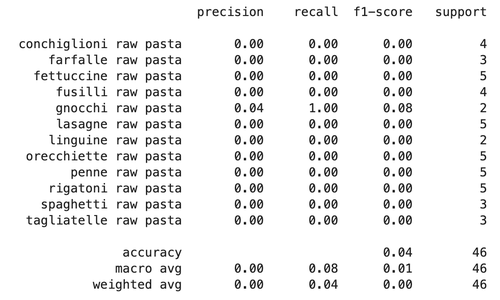

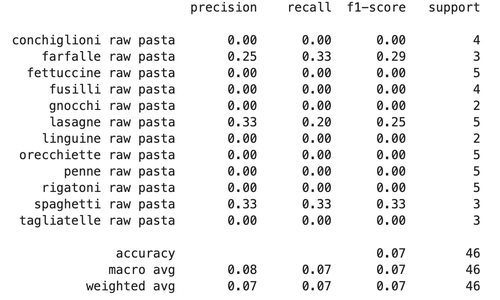

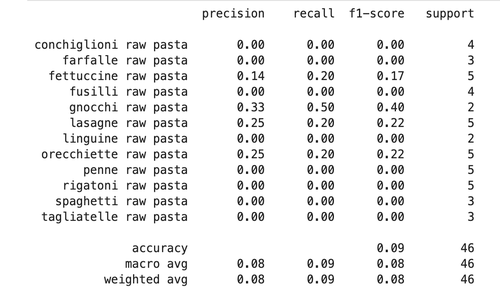

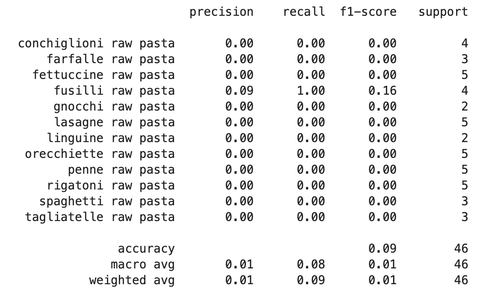

In [12]:
# Displaying the metrics for each model trained
list_of_metrics_imgs = ['pasta_metrics_1st_model.png', 'pasta_metrics_2nd_model.png', 'pasta_metrics_3rd_model.png', 'pasta_metrics_4th_model.png']

from IPython.display import Image
from PIL import Image

for img in list_of_metrics_imgs:
    image = Image.open(img)
    image = image.resize((500,300),Image.ANTIALIAS)
    display(image)

### Hyperparameter tuning optimization made for each model trained:

#first model's hyperparameters:
- learning rate = 0.1
- epochs = 20

#second model's hyperparameters:
- learning rate = 0.001
- epochs = 50

#third model's hyperparameters:
- learning rate = 0.00001
- epochs = 100

#fourth model's hyperparameters:
- learning rate = 0.1
- epochs = 200